## Machine learning models

Now, we will train and evaluate two machine learning quantile regression models, XGBoost and a Random Forest from quantile-forest. Our final model will be a hybrid of the two that produces a probabilistic forecast in the form of prediction intervals based on a deterministic forecast.

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from quantile_forest import RandomForestQuantileRegressor
import joblib

### Get data ready
Read in the DataFrame we created in the last notebook:

In [45]:
df = pd.read_pickle('data_files/full_2021_2023_dataset.pkl')

In [46]:
df.head()

,p_ac_all_fcast,p_ac_all_fcast_max,p_ac_all_fcast_min,p_ac_all_cs,level_0,p_ac_all_act,tcc_std,max_min_norm,abs_err,norm_abs_err,csi_norm_abs_err,csi_actual,csi_fcast,hour,month,el,zen,az
time_center_labeled,,,,,,,,,,,,,,,,,,
2021-01-01 09:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.657303,NaN,0.000000,0.00000,NaN,NaN,NaN,9,1,-44.725579,134.725579,90.865286
2021-01-01 10:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.346134,NaN,0.000000,0.00000,NaN,NaN,NaN,10,1,-32.169594,122.169594,98.221778
2021-01-01 11:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.346134,NaN,0.000000,0.00000,NaN,NaN,NaN,11,1,-19.832171,109.832171,105.126225
2021-01-01 12:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.346134,NaN,0.000000,0.00000,NaN,NaN,NaN,12,1,-7.896291,97.896291,112.278339
2021-01-01 13:00:00+00:00,46.237118,146.468144,4.036621,827.123924,0.0,32.438303,4.919961,0.172201,13.798815,0.00372,0.016683,0.039218,0.055901,13,1,3.619760,86.380240,120.212465


Filter by dropping nighttime values:

In [47]:
# setup test and training data
filtered_df = df.dropna()
approx_nameplate = df.p_ac_all_cs.max() # use max of clear sky power as proxy for nameplate rating
filtered_df = filtered_df[filtered_df['p_ac_all_cs'] >= approx_nameplate*.001]

Calculate the normalized mean absolute error (NMAE) of our input deterministic forecast, just for reference:

In [48]:
orig_nmae = filtered_df['norm_abs_err'].mean()
print('original NMAE: ' + "{:.2f}".format(orig_nmae*100) + '%')

original NMAE: 8.44%


### Train the XGBoost quantile regression
Let's train an XGBoost quantile regression model with methods based on [1]. 

We will define a prediction interval (PI) list for training our XGBoost model, naming that variable `pi_list_xgb`. The final PI values we are targetting are `[99.5%, 99%, 98%, 95%, and 50%]`, and the values for `pi_list_xgb`, `[99.95%, 99.9%, 99%, 96%, 57%]` have been manually adjusted to give us results close to those PI values.

The features used in the model are:
- standard deviation of weighted average TCC from GEFS
- normalized max-min power from HRRR
- clear sky normalized deterministic power forecast
- solar zenith and azimuth
- month of the year

Solar elevation and hour of day are also available, but were not found to be helpful, so they are commented out below.

We will train on 2021 data, test with 2022, and do a final evaluation with 2023. We will exclude 2021-04-09 through 2021-04-12, a time range we looked at early on, so we can revist what our model would have predicted in that time range. 

[1] https://xgboost.readthedocs.io/en/latest/python/examples/quantile_regression.html

In [49]:
pi_list_xgb = [.9995, .999, .99, .96, .57] 
pi_list = pi_list_xgb

percentile_list = [(1-x)/2 for x in pi_list] + [.5] + [1-(1-x)/2 for x in reversed(pi_list)]
percentile_list = [round(elem, 6) for elem in percentile_list]
num_intervals = len(pi_list)

alpha = percentile_list
evals_result = {}

# setup test and training data
X=filtered_df[['tcc_std']].copy()
X['max_min_norm'] = filtered_df['max_min_norm']
X['csi_fcast'] = filtered_df['csi_fcast']
X['zen'] = filtered_df['zen']
X['az'] = filtered_df['az']
X['month'] = filtered_df['month']
# X['hour'] = filtered_df['hour']
# X['el'] = filtered_df['el']

y = filtered_df['csi_actual']

## year split
X_train = X[(X.index.year == 2021) & ((X.index < '2021-04-09') | (X.index > '2021-04-13'))]
y_train = y[(X.index.year == 2021) & ((X.index < '2021-04-09') | (X.index > '2021-04-13'))]
X_test = X[X.index.year == 2022]
y_test = y[X.index.year == 2022]
X = X[(X.index.year >= 2021) & (X.index.year <= 2022)]
y = y[(y.index.year >= 2021) & (y.index.year <= 2022)]

In [50]:
# We will be using the `hist` tree method, quantile DMatrix can be used to preserve
# memory.
# Do not use the `exact` tree method for quantile regression, otherwise the
# performance might drop.
Xy = xgb.QuantileDMatrix(X, y)
# use Xy as a reference
Xy_test = xgb.QuantileDMatrix(X_test, y_test, ref=Xy)

booster = xgb.train(
    {
        # Use the quantile objective function.
        "objective": "reg:quantileerror",
        "tree_method": "hist",
        "quantile_alpha": alpha,
        # Let's try not to overfit.
        "learning_rate": 0.005,
        "max_depth": 5,
    },
    Xy,
    num_boost_round=2000,
    early_stopping_rounds=20,
    # The evaluation result is a weighted average across multiple quantiles.
    evals=[(Xy, "Train"), (Xy_test, "Test")],
    evals_result=evals_result,
    verbose_eval=False,
)

Save the model:

In [51]:
# save model
booster.save_model("regression_models/xgboost_model.json")

In [52]:
# load
booster = xgb.Booster()
booster.load_model("regression_models/xgboost_model.json")

Look at some model info:

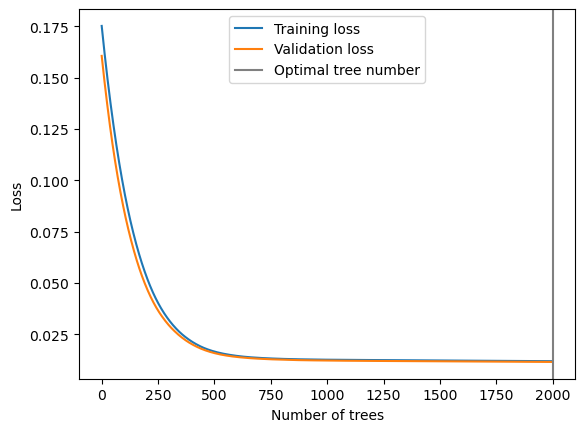

In [53]:
# from https://mljar.com/blog/xgboost-early-stopping/
# plt.figure(figsize=(10,7))
plt.plot(evals_result['Train']['quantile'], label="Training loss")
plt.plot(evals_result['Test']['quantile'], label="Validation loss")
plt.axvline(booster.best_iteration, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

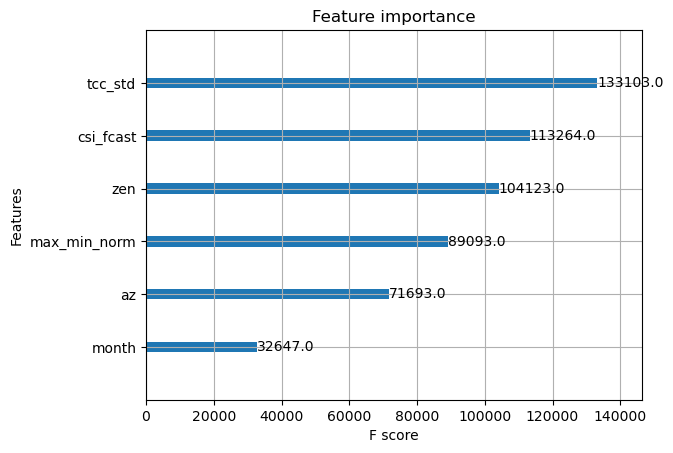

In [54]:
xgb.plot_importance(booster)

Above, we can see which features are most important for our XGBoost model. Later we can compare those to the feature importance in the Random Forest model. 

Now, let's run the model using 2022 data:

In [55]:
# predict using model
y_pred = booster.inplace_predict(X_test)

In [56]:
# create a results dataframe
result_df = X_test.copy()

# merge orginal DF, marking duplicate columns and then dropping them
result_df = result_df.merge(df, left_index=True, right_index=True, suffixes=('', '_drop'))
result_df.drop(result_df.filter(regex='_drop$').columns, axis=1, inplace=True)

# adding CS-normalized quantiles/percentiles, and then un-normalizing them to get power
for i in range(len(percentile_list)):
    result_df[str(percentile_list[i])+'_csi']=y_pred[:,i]
for i in range(len(percentile_list)):
    result_df[str(percentile_list[i])+'_p_ac']=y_pred[:,i]*result_df['p_ac_all_cs']

# fill in overnight 
result_df = result_df.reset_index().set_index('time_center_labeled').asfreq('1h')

Here's a helper function that calculates coverage fraction, also referred to as prediction interval coverage probability (PICP). It is the fraction of time that observations fall within a prediction interval. 

We can use this to evaluate how well calibrated our model is. For example, we want 90% of all observations to fall within the 90% PI (a coverage fraction of 90%). If only 85% of observations fall in the 90% PI, a coverage fraction of 85%, then our model is "underdispersed" and overconfident. 

In [57]:
# from https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_quantile.html
def coverage_fraction(y, y_low, y_high):
    return np.mean(np.logical_and(y >= y_low, y <= y_high))

Calculate coverage fraction and NMAE of the central forecast:

In [58]:
# coverage fraction and error:
cf = {}
for i in range(num_intervals):
    cf[i] = coverage_fraction(y_test,
                              y_pred[:,i],
                              y_pred[:,len(percentile_list)-i-1]
    )

print('target prediction intervals:')
print(pi_list)
print('resulting coverage fraction (rounded to 3 places):')
print([ '%.3f' % elem for elem in list(cf.values())])
orig_nmae = filtered_df['norm_abs_err'].mean()
print('original NMAE: ' + "{:.2f}".format(orig_nmae*100) + '%')
adjusted_nmae = (result_df[str(percentile_list[int((len(percentile_list)-1)/2)])+'_p_ac'] - result_df['p_ac_all_act']).abs().mean()/approx_nameplate
print('adjusted NMAE: ' + "{:.2f}".format(adjusted_nmae*100) + '%')

target prediction intervals:
[0.9995, 0.999, 0.99, 0.96, 0.57]
resulting coverage fraction (rounded to 3 places):
['0.992', '0.994', '0.983', '0.957', '0.560']
original NMAE: 8.44%
adjusted NMAE: 7.03%


We see a noteable improvement in NMAE, and our coverage fraction is pretty good, at least below the highest PI.

Let's also look at the sharpness, also known as the prediction interval normalized average width (PINAW). This gives us an idea of how much skill our forecast has. For example, very good coverage fraction can be achieved be simply summarizing historical statistics and using the same prediction intervals every day, but that would result in a forecast with excessivly wide prediction intervals that are not "sharp". 

In [59]:
# sharpness
print('target PI : resulting CF : width')
for i in range(num_intervals):
    lower = result_df[str(percentile_list[i])+'_p_ac'] # lower
    upper = result_df[str(percentile_list[len(percentile_list)-i-1])+'_p_ac'] # upper
    print(str(pi_list[i]), ":", "{:.3f}".format(list(cf.values())[i]), ":", (upper-lower).mean()/approx_nameplate)

print('for zenith < 75:')

mask_zen = (result_df['zen'] < 75) 

cf_mask = {}
for i in range(num_intervals):
    cf_mask[i] = coverage_fraction(result_df['p_ac_all_act'][mask_zen],
                              result_df[str(percentile_list[i])+'_p_ac'][mask_zen],
                              result_df[str(percentile_list[len(percentile_list)-i-1])+'_p_ac'][mask_zen]
    )

for i in range(num_intervals):
    lower = result_df[str(percentile_list[i])+'_p_ac'][mask_zen] # lower
    upper = result_df[str(percentile_list[len(percentile_list)-i-1])+'_p_ac'][mask_zen] # upper
    print(str(pi_list[i]), ":", "{:.3f}".format(list(cf_mask.values())[i]), ":", (upper-lower).mean()/approx_nameplate)

target PI : resulting CF : width
0.9995 : 0.992 : 0.6745222856713913
0.999 : 0.994 : 0.6570725027385858
0.99 : 0.983 : 0.48219303075377395
0.96 : 0.957 : 0.3767447675847643
0.57 : 0.560 : 0.14063316005117266
for zenith < 75:
0.9995 : 0.997 : 0.7818396873533291
0.999 : 0.999 : 0.7611906962148535
0.99 : 0.987 : 0.5609222253955345
0.96 : 0.958 : 0.43995249034942363
0.57 : 0.557 : 0.16381326775495783


Now try that XGBoost model but with 2023 test data:

In [60]:
# setup 2023 test
X=filtered_df[['tcc_std']].copy()
X['max_min_norm'] = filtered_df['max_min_norm']
X['csi_fcast'] = filtered_df['csi_fcast']
X['zen'] = filtered_df['zen']
X['az'] = filtered_df['az']
X['month'] = filtered_df['month']
# X['hour'] = filtered_df['hour']
# X['el'] = filtered_df['el']

y = filtered_df['csi_actual']

X_test = X[X.index.year == 2023]
y_test = y[X.index.year == 2023]

# predict using model
y_pred = booster.inplace_predict(X_test)

In [61]:
# create a results dataframe
result_df = X_test.copy()

# merge orginal DF, marking duplicate columns and then dropping them
result_df = result_df.merge(df, left_index=True, right_index=True, suffixes=('', '_drop'))
result_df.drop(result_df.filter(regex='_drop$').columns, axis=1, inplace=True)

# adding CS-normalized quantiles/percentiles, and then un-normalizing them to get power
for i in range(len(percentile_list)):
    result_df[str(percentile_list[i])+'_csi']=y_pred[:,i]
for i in range(len(percentile_list)):
    result_df[str(percentile_list[i])+'_p_ac']=y_pred[:,i]*result_df['p_ac_all_cs']

# fill in overnight 
result_df = result_df.reset_index().set_index('time_center_labeled').asfreq('1h')

And look at coverage fraction and error:

In [62]:
# coverage fraction and error:
cf = {}
for i in range(num_intervals):
    cf[i] = coverage_fraction(y_test,
                              y_pred[:,i],
                              y_pred[:,len(percentile_list)-i-1]
    )

print('target prediction intervals:')
print(pi_list)
print('resulting coverage fraction (rounded to 3 places):')
print([ '%.3f' % elem for elem in list(cf.values())])
orig_nmae = filtered_df['norm_abs_err'].mean()
print('original NMAE: ' + "{:.2f}".format(orig_nmae*100) + '%')
adjusted_nmae = (result_df[str(percentile_list[int((len(percentile_list)-1)/2)])+'_p_ac'] - result_df['p_ac_all_act']).abs().mean()/approx_nameplate
print('adjusted NMAE: ' + "{:.2f}".format(adjusted_nmae*100) + '%')

target prediction intervals:
[0.9995, 0.999, 0.99, 0.96, 0.57]
resulting coverage fraction (rounded to 3 places):
['0.968', '0.966', '0.948', '0.904', '0.504']
original NMAE: 8.44%
adjusted NMAE: 7.96%


And look at sharpness:

In [63]:
# sharpness
print('target PI : resulting CF : width')
for i in range(num_intervals):
    lower = result_df[str(percentile_list[i])+'_p_ac'] # lower
    upper = result_df[str(percentile_list[len(percentile_list)-i-1])+'_p_ac'] # upper
    print(str(pi_list[i]), ":", "{:.3f}".format(list(cf.values())[i]), ":", (upper-lower).mean()/approx_nameplate)

print('for zenith < 75:')

mask_zen = (result_df['zen'] < 75) 

cf_mask = {}
for i in range(num_intervals):
    cf_mask[i] = coverage_fraction(result_df['p_ac_all_act'][mask_zen],
                              result_df[str(percentile_list[i])+'_p_ac'][mask_zen],
                              result_df[str(percentile_list[len(percentile_list)-i-1])+'_p_ac'][mask_zen]
    )

for i in range(num_intervals):
    lower = result_df[str(percentile_list[i])+'_p_ac'][mask_zen] # lower
    upper = result_df[str(percentile_list[len(percentile_list)-i-1])+'_p_ac'][mask_zen] # upper
    print(str(pi_list[i]), ":", "{:.3f}".format(list(cf_mask.values())[i]), ":", (upper-lower).mean()/approx_nameplate)

target PI : resulting CF : width
0.9995 : 0.968 : 0.6769859621315966
0.999 : 0.966 : 0.6596213092119021
0.99 : 0.948 : 0.4955499212228397
0.96 : 0.904 : 0.3915847757042059
0.57 : 0.504 : 0.14469701104344537
for zenith < 75:
0.9995 : 0.976 : 0.785043224752403
0.999 : 0.974 : 0.7644905438950393
0.99 : 0.955 : 0.578042536105144
0.96 : 0.907 : 0.4586268620065556
0.57 : 0.508 : 0.16906880728973453


And here are some plots of sample time ranges:

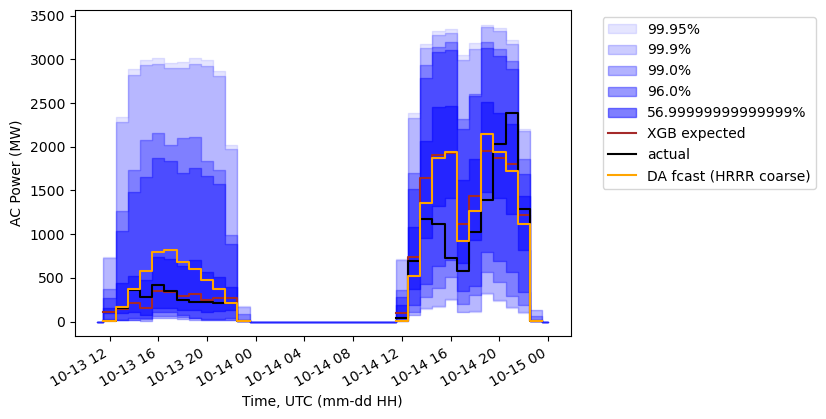

In [64]:
mask_start = '2023-10-13 11:00'
mask_end = '2023-10-15'
# mask_start = '2022-8-15 6:00'
# mask_end = '2022-8-19 6:00'
mask = (result_df.index >= mask_start) & (result_df.index <= mask_end)

for i in range(num_intervals):
    alph=0.1+(i/10.)
    plt.fill_between(result_df.index[mask],# x
                     result_df[str(percentile_list[i])+'_p_ac'][mask].fillna(0), # lower
                     result_df[str(percentile_list[len(percentile_list)-i-1])+'_p_ac'][mask].fillna(0), # upper
                     color='blue',
                     alpha=alph,
                     step='mid',
                     label=(str(pi_list[i]*100)+'%'))
    
plt.plot(result_df.index[mask],
         result_df[str(percentile_list[int((len(percentile_list)-1)/2)])+'_p_ac'][mask],
         label='XGB expected',color='brown', drawstyle='steps-mid')
plt.plot(result_df.index[mask],result_df['p_ac_all_act'][mask],label='actual',color='black', drawstyle='steps-mid')
plt.plot(result_df.index[mask],result_df['p_ac_all_fcast'][mask],label='DA fcast (HRRR coarse)',color='orange', drawstyle='steps-mid')
plt.ylabel('AC Power (MW)')
# plt.ylim([0,4500])
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.gcf().autofmt_xdate()
plt.xlabel('Time, UTC (mm-dd HH)')
plt.show()

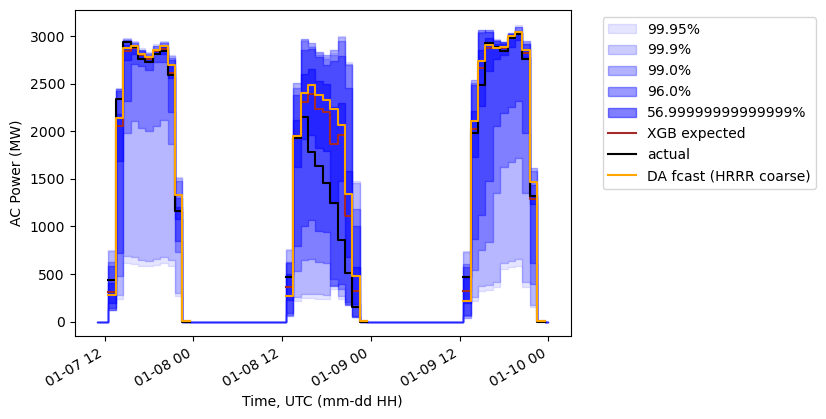

In [65]:
mask_start = '2023-1-7 11:00'
mask_end = '2023-1-10'

mask = (result_df.index >= mask_start) & (result_df.index <= mask_end)

for i in range(num_intervals):
    alph=0.1+(i/10.)
    plt.fill_between(result_df.index[mask],# x
                     result_df[str(percentile_list[i])+'_p_ac'][mask].fillna(0), # lower
                     result_df[str(percentile_list[len(percentile_list)-i-1])+'_p_ac'][mask].fillna(0), # upper
                     color='blue',
                     alpha=alph,
                     step='mid',
                     label=(str(pi_list[i]*100)+'%'))
    
plt.plot(result_df.index[mask],
         result_df[str(percentile_list[int((len(percentile_list)-1)/2)])+'_p_ac'][mask],
         label='XGB expected',color='brown', drawstyle='steps-mid')
plt.plot(result_df.index[mask],result_df['p_ac_all_act'][mask],label='actual',color='black', drawstyle='steps-mid')
plt.plot(result_df.index[mask],result_df['p_ac_all_fcast'][mask],label='DA fcast (HRRR coarse)',color='orange', drawstyle='steps-mid')
plt.ylabel('AC Power (MW)')
# plt.ylim([0,4500])
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.gcf().autofmt_xdate()
plt.xlabel('Time, UTC (mm-dd HH)')
plt.show()

In [66]:
result_df_XGB_2023 = result_df.copy()

We get slightly worse performance than we did for 2022. The "boosting" step may be slightly overfitting.

Let's try a Random Forest Quantile Regressor. This one is published by Zillow. There's an alternative version published in Scikit-garden (https://scikit-garden.github.io/examples/QuantileRegressionForests/), but it is outdated and not compatible with some of the other package versions we have.

We have a prediction interval list for the Random Forest model, `pi_list_rf`, setup in the same way as the PI list for the XGBoost model earlier, where they have been manually tuned to result in the target PI values that we want. We use the same features as well.

Here, we can train with both 2021 and 2022, since we don't need to hold 2022 for the eval/boost step needed in XGBoost. We will exclude 2024-04-09 through 2024-04-12 again, as well.

In [67]:
pi_list_rf = [.995, .99, .98, .95, .5]
pi_list = pi_list_rf

percentile_list = [(1-x)/2 for x in pi_list] + [.5] + [1-(1-x)/2 for x in reversed(pi_list)]
percentile_list = [round(elem, 6) for elem in percentile_list]
num_intervals = len(pi_list)

# setup test and training data
X=filtered_df[['tcc_std']].copy()
X['max_min_norm'] = filtered_df['max_min_norm']
X['csi_fcast'] = filtered_df['csi_fcast']
X['zen'] = filtered_df['zen']
X['az'] = filtered_df['az']
X['month'] = filtered_df['month']
# X['hour'] = filtered_df['hour']
# X['el'] = filtered_df['el']

y = filtered_df['csi_actual']

## year split
X_train = X[(X.index.year >= 2021) & (X.index.year <= 2022) & ((X.index < '2021-04-09') | (X.index > '2021-04-13'))]
y_train = y[(y.index.year >= 2021) & (y.index.year <= 2022) & ((X.index < '2021-04-09') | (X.index > '2021-04-13'))]
X_test = X[X.index.year == 2023]
y_test = y[X.index.year == 2023]

qrf = RandomForestQuantileRegressor(n_estimators=200, criterion="absolute_error",
                                    min_samples_leaf=15, max_samples_leaf=18, max_features=0.5,
                                    random_state=42)
qrf.fit(X_train, y_train)
y_pred = qrf.predict(X_test, quantiles=percentile_list)

c:\Users\willh\miniforge3\envs\pvlib_herbie_env3\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(


In [68]:
# create a results dataframe
result_df = X_test.copy()

# merge orginal DF, marking duplicate columns and then dropping them
result_df = result_df.merge(df, left_index=True, right_index=True, suffixes=('', '_drop'))
result_df.drop(result_df.filter(regex='_drop$').columns, axis=1, inplace=True)

# adding CS-normalized quantiles/percentiles, and then un-normalizing them to get power
for i in range(len(percentile_list)):
    result_df[str(percentile_list[i])+'_csi']=y_pred[:,i]
for i in range(len(percentile_list)):
    result_df[str(percentile_list[i])+'_p_ac']=y_pred[:,i]*result_df['p_ac_all_cs']

# fill in overnight 
result_df = result_df.reset_index().set_index('time_center_labeled').asfreq('1h')

In [69]:
# coverage fraction and error:
cf = {}
for i in range(num_intervals):
    cf[i] = coverage_fraction(y_test,
                              y_pred[:,i],
                              y_pred[:,len(percentile_list)-i-1]
    )

print('target prediction intervals:')
print(pi_list)
print('resulting coverage fraction (rounded to 3 places):')
print([ '%.3f' % elem for elem in list(cf.values())])
orig_nmae = filtered_df['norm_abs_err'].mean()
print('original NMAE: ' + "{:.2f}".format(orig_nmae*100) + '%')
adjusted_nmae = (result_df[str(percentile_list[int((len(percentile_list)-1)/2)])+'_p_ac'] - result_df['p_ac_all_act']).abs().mean()/approx_nameplate
print('adjusted NMAE: ' + "{:.2f}".format(adjusted_nmae*100) + '%')

target prediction intervals:
[0.995, 0.99, 0.98, 0.95, 0.5]
resulting coverage fraction (rounded to 3 places):
['0.991', '0.989', '0.981', '0.954', '0.510']
original NMAE: 8.44%
adjusted NMAE: 7.79%


In [70]:
# sharpness
print('target PI : resulting CF : width')
for i in range(num_intervals):
    lower = result_df[str(percentile_list[i])+'_p_ac'] # lower
    upper = result_df[str(percentile_list[len(percentile_list)-i-1])+'_p_ac'] # upper
    print(str(pi_list[i]), ":", "{:.3f}".format(list(cf.values())[i]), ":", (upper-lower).mean()/approx_nameplate)

print('for zenith < 75:')

mask_zen = (result_df['zen'] < 75) 

cf_mask = {}
for i in range(num_intervals):
    cf_mask[i] = coverage_fraction(result_df['p_ac_all_act'][mask_zen],
                              result_df[str(percentile_list[i])+'_p_ac'][mask_zen],
                              result_df[str(percentile_list[len(percentile_list)-i-1])+'_p_ac'][mask_zen]
    )

for i in range(num_intervals):
    lower = result_df[str(percentile_list[i])+'_p_ac'][mask_zen] # lower
    upper = result_df[str(percentile_list[len(percentile_list)-i-1])+'_p_ac'][mask_zen] # upper
    print(str(pi_list[i]), ":", "{:.3f}".format(list(cf_mask.values())[i]), ":", (upper-lower).mean()/approx_nameplate)

target PI : resulting CF : width
0.995 : 0.991 : 0.5843910342961928
0.99 : 0.989 : 0.5433779869985661
0.98 : 0.981 : 0.49278786321970236
0.95 : 0.954 : 0.40857402818441163
0.5 : 0.510 : 0.126676315759715
for zenith < 75:
0.995 : 0.991 : 0.6741405583190401
0.99 : 0.988 : 0.6267982838148387
0.98 : 0.979 : 0.5685810182629771
0.95 : 0.949 : 0.47087702539521986
0.5 : 0.485 : 0.1459525204460232


You can see that we don't _quite_ hit our most extreme PI, but it is very close. 

Now, let's look at feature importance for the RF model:

In [71]:
print(qrf.feature_importances_)
print(X_test.columns.to_list())

[0.04805698 0.09983673 0.65129343 0.15776385 0.03248883 0.01056019]
['tcc_std', 'max_min_norm', 'csi_fcast', 'zen', 'az', 'month']


We can then normalize the feature weights from the XGBoost model to compare them. I _think_ that the XGBoost importance type of `gain` is closest to the feature importance metric for the Random Forest. Compare https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.Booster.get_score with https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.feature_importances_.

{'tcc_std': 0.03666995249029145, 'max_min_norm': 0.024108021278302298, 'csi_fcast': 0.8073030093123457, 'zen': 0.0695509175610769, 'az': 0.03906179433041965, 'month': 0.023306305027564003}


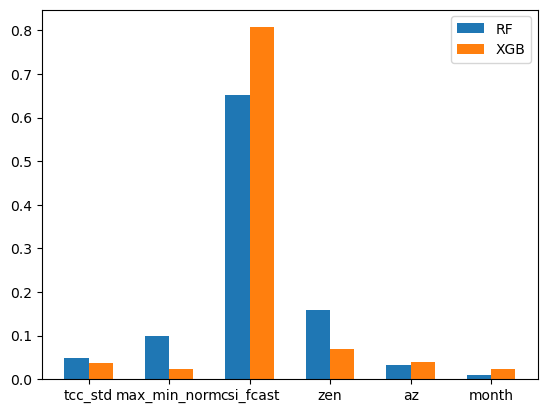

In [72]:
# calculate normalized feature weights for the XGboost model
booster_score_dict = booster.get_score(importance_type='gain')
sum_of_weights = sum(booster.get_score(importance_type='gain').values())
booster_normalized_scores_dict = {k:v/sum_of_weights for (k,v) in booster_score_dict.items()}

print(booster_normalized_scores_dict)

# Mak a plot
width = 0.3
x_labels = X_test.columns.to_list()
length = len(x_labels)
x = np.arange(length)

plt.bar(x-.5*width,
        qrf.feature_importances_,
        width,
        label = 'RF')
plt.bar(x+.5*width,
        booster_normalized_scores_dict.values(),
        width,
        label='XGB')
plt.legend()
# plt.set_xticklabels(x_labels)
plt.xticks(x, x_labels)
plt.show()

In both cases, the deterministic forecast is most important, followed by solar zenith angle, but for the Random Forest, normalized max-min is third, while for XGBoost standard deviation of weighted average TCC is third. 

Here are plots for the same sample time ranges we used earlier:

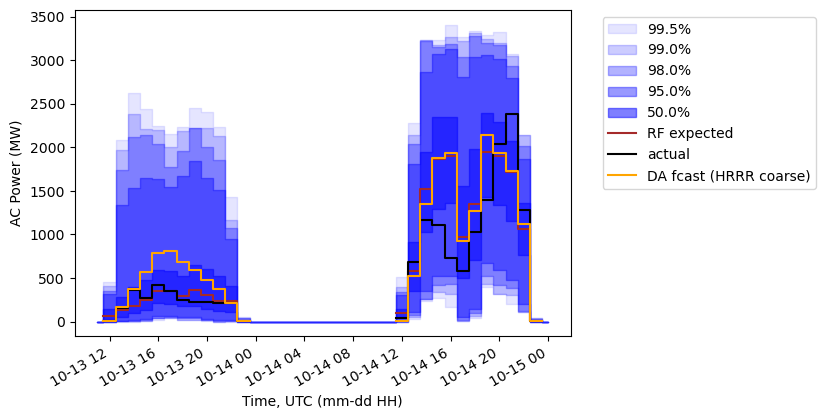

In [73]:
mask_start = '2023-10-13 11:00'
mask_end = '2023-10-15'

mask = (result_df.index >= mask_start) & (result_df.index <= mask_end)

for i in range(num_intervals):
    alph=0.1+(i/10.)
    plt.fill_between(result_df.index[mask],# x
                     result_df[str(percentile_list[i])+'_p_ac'][mask].fillna(0), # lower
                     result_df[str(percentile_list[len(percentile_list)-i-1])+'_p_ac'][mask].fillna(0), # upper
                     color='blue',
                     alpha=alph,
                     step='mid',
                     label=(str(pi_list[i]*100)+'%'))
    
plt.plot(result_df.index[mask],
         result_df[str(percentile_list[int((len(percentile_list)-1)/2)])+'_p_ac'][mask],
         label='RF expected',color='brown', drawstyle='steps-mid')
plt.plot(result_df.index[mask],result_df['p_ac_all_act'][mask],label='actual',color='black', drawstyle='steps-mid')
plt.plot(result_df.index[mask],result_df['p_ac_all_fcast'][mask],label='DA fcast (HRRR coarse)',color='orange', drawstyle='steps-mid')
plt.ylabel('AC Power (MW)')
# plt.ylim([0,4500])
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.gcf().autofmt_xdate()
plt.xlabel('Time, UTC (mm-dd HH)')
plt.show()

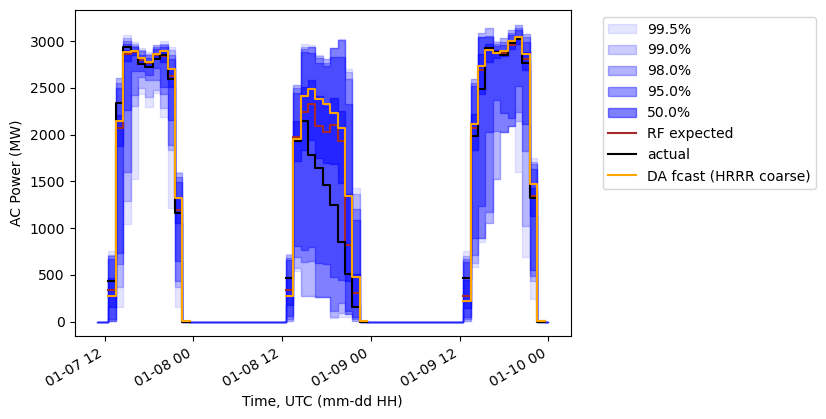

In [74]:
mask_start = '2023-1-7 11:00'
mask_end = '2023-1-10'

mask = (result_df.index >= mask_start) & (result_df.index <= mask_end)

for i in range(num_intervals):
    alph=0.1+(i/10.)
    plt.fill_between(result_df.index[mask],# x
                     result_df[str(percentile_list[i])+'_p_ac'][mask].fillna(0), # lower
                     result_df[str(percentile_list[len(percentile_list)-i-1])+'_p_ac'][mask].fillna(0), # upper
                     color='blue',
                     alpha=alph,
                     step='mid',
                     label=(str(pi_list[i]*100)+'%'))
    
plt.plot(result_df.index[mask],
         result_df[str(percentile_list[int((len(percentile_list)-1)/2)])+'_p_ac'][mask],
         label='RF expected',color='brown', drawstyle='steps-mid')
plt.plot(result_df.index[mask],result_df['p_ac_all_act'][mask],label='actual',color='black', drawstyle='steps-mid')
plt.plot(result_df.index[mask],result_df['p_ac_all_fcast'][mask],label='DA fcast (HRRR coarse)',color='orange', drawstyle='steps-mid')
plt.ylabel('AC Power (MW)')
# plt.ylim([0,4500])
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.gcf().autofmt_xdate()
plt.xlabel('Time, UTC (mm-dd HH)')
plt.show()

We get especially good performance on clear days like Jan 7 2023.

Let's hold on to the results DataFrame for use in a bit:

In [75]:
result_df_RF_2023 = result_df.copy()

And export our RF model:

In [76]:
joblib.dump(qrf, 'regression_models/qrf_file.joblib')

['regression_models/qrf_file.joblib']

In [77]:
qrf = joblib.load('regression_models/qrf_file.joblib')

Now, let's look at hybrid of RF and XGB. RF seems much better on clear days, and XGB seems better on overcast/partly cloudy days. Because we have good coverage for both, let's merge them to pick the narrowest of both.

Because the RF seems to do better with the extremes, we will set the extreme values from the RF model. We will also pick the central value (P50) from the RF model, although it's a toss-up between the two in terms of NMAE. Other metrics may be useful in determining which is actually best for the central estimate.

In [78]:
# create new hyrbid dataframe, starting with RF because PIs were accurate so we can keep column names
result_df_hybrid_2023 = result_df_RF_2023.copy()

# use PIs from RF model
pi_list = pi_list_rf

percentile_list = [(1-x)/2 for x in pi_list] + [.5] + [1-(1-x)/2 for x in reversed(pi_list)]
percentile_list = [round(elem, 6) for elem in percentile_list]
num_intervals = len(pi_list)

In [79]:
# find columns that end in `_p_ac` (e.g., '0.015_p_ac')
rf_columns = result_df_RF_2023.filter(regex='_p_ac$').columns
xgb_columns = result_df_XGB_2023.filter(regex='_p_ac$').columns

# loop through, selecting max of lower bounds and min of upper bounds
for i in range(len(rf_columns)):
    if i == 0: # first
        print('extreme lower bound from rf', rf_columns[i])
        result_df_hybrid_2023[rf_columns[i]] = result_df_RF_2023[rf_columns[i]]
    elif i == len(rf_columns)-1: # last
        print('extreme upper bound from rf', rf_columns[i])
        result_df_hybrid_2023[rf_columns[i]] = result_df_RF_2023[rf_columns[i]]
    elif i < (len(rf_columns)-1)/2:
        print('lower bounds', rf_columns[i], xgb_columns[i])
        result_df_hybrid_2023[rf_columns[i]] = np.maximum(result_df_XGB_2023[xgb_columns[i]], result_df_RF_2023[rf_columns[i]])
        # result_df_hybrid_2023[rf_columns[i]] = pd.DataFrame([result_df_XGB_2023[xgb_columns[i]], result_df_RF_2023[rf_columns[i]]]).max(axis=0)
    elif i == (len(rf_columns)-1)/2:
        print('mid', rf_columns[i], xgb_columns[i])
        result_df_hybrid_2023[rf_columns[i]] = result_df_RF_2023[rf_columns[i]]
    else:
        print('upper bounds', rf_columns[i], xgb_columns[i])
        result_df_hybrid_2023[rf_columns[i]] = np.minimum(result_df_XGB_2023[xgb_columns[i]], result_df_RF_2023[rf_columns[i]])


extreme lower bound from rf 0.0025_p_ac
lower bounds 0.005_p_ac 0.0005_p_ac
lower bounds 0.01_p_ac 0.005_p_ac
lower bounds 0.025_p_ac 0.02_p_ac
lower bounds 0.25_p_ac 0.215_p_ac
mid 0.5_p_ac 0.5_p_ac
upper bounds 0.75_p_ac 0.785_p_ac
upper bounds 0.975_p_ac 0.98_p_ac
upper bounds 0.99_p_ac 0.995_p_ac
upper bounds 0.995_p_ac 0.9995_p_ac
extreme upper bound from rf 0.9975_p_ac


In [80]:
result_df = result_df_hybrid_2023.copy()

In [81]:
# coverage fraction and error:
cf = {}
for i in range(num_intervals):
    cf[i] = coverage_fraction(y_test,
                              y_pred[:,i],
                              y_pred[:,len(percentile_list)-i-1]
    )

print('target prediction intervals:')
print(pi_list)
print('resulting coverage fraction (rounded to 3 places):')
print([ '%.3f' % elem for elem in list(cf.values())])
orig_nmae = filtered_df['norm_abs_err'].mean()
print('original NMAE: ' + "{:.2f}".format(orig_nmae*100) + '%')
adjusted_nmae = (result_df[str(percentile_list[int((len(percentile_list)-1)/2)])+'_p_ac'] - result_df['p_ac_all_act']).abs().mean()/approx_nameplate
print('adjusted NMAE: ' + "{:.2f}".format(adjusted_nmae*100) + '%')

target prediction intervals:
[0.995, 0.99, 0.98, 0.95, 0.5]
resulting coverage fraction (rounded to 3 places):
['0.991', '0.989', '0.981', '0.954', '0.510']
original NMAE: 8.44%
adjusted NMAE: 7.79%


In [82]:
# sharpness
print('target PI : resulting CF : width')
for i in range(num_intervals):
    lower = result_df[str(percentile_list[i])+'_p_ac'] # lower
    upper = result_df[str(percentile_list[len(percentile_list)-i-1])+'_p_ac'] # upper
    print(str(pi_list[i]), ":", "{:.3f}".format(list(cf.values())[i]), ":", (upper-lower).mean()/approx_nameplate)

print('for zenith < 75:')

mask_zen = (result_df['zen'] < 75) 

cf_mask = {}
for i in range(num_intervals):
    cf_mask[i] = coverage_fraction(result_df['p_ac_all_act'][mask_zen],
                              result_df[str(percentile_list[i])+'_p_ac'][mask_zen],
                              result_df[str(percentile_list[len(percentile_list)-i-1])+'_p_ac'][mask_zen]
    )

for i in range(num_intervals):
    lower = result_df[str(percentile_list[i])+'_p_ac'][mask_zen] # lower
    upper = result_df[str(percentile_list[len(percentile_list)-i-1])+'_p_ac'][mask_zen] # upper
    print(str(pi_list[i]), ":", "{:.3f}".format(list(cf_mask.values())[i]), ":", (upper-lower).mean()/approx_nameplate)

target PI : resulting CF : width
0.995 : 0.991 : 0.5843910342961928
0.99 : 0.989 : 0.5325690061307813
0.98 : 0.981 : 0.4588049516607297
0.95 : 0.954 : 0.3694330253826054
0.5 : 0.510 : 0.1173568601153544
for zenith < 75:
0.995 : 0.991 : 0.6741405583190401
0.99 : 0.971 : 0.6152362620781178
0.98 : 0.951 : 0.5332430190687479
0.95 : 0.901 : 0.43113240042485207
0.5 : 0.437 : 0.1366625443269991


Again, we fall just a little short of our target PIs, but that is expected based on the way this hybrid is created. 

And plots of the sample time ranges:

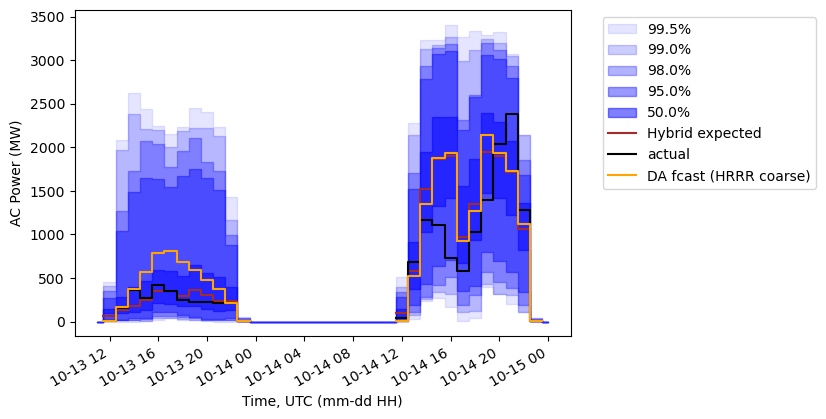

In [83]:
mask_start = '2023-10-13 11:00'
mask_end = '2023-10-15'

mask = (result_df.index >= mask_start) & (result_df.index <= mask_end)

for i in range(num_intervals):
    alph=0.1+(i/10.)
    plt.fill_between(result_df.index[mask],# x
                     result_df[str(percentile_list[i])+'_p_ac'][mask].fillna(0), # lower
                     result_df[str(percentile_list[len(percentile_list)-i-1])+'_p_ac'][mask].fillna(0), # upper
                     color='blue',
                     alpha=alph,
                     step='mid',
                     label=(str(pi_list[i]*100)+'%'))
    
plt.plot(result_df.index[mask],
         result_df[str(percentile_list[int((len(percentile_list)-1)/2)])+'_p_ac'][mask],
         label='Hybrid expected',color='brown', drawstyle='steps-mid')
plt.plot(result_df.index[mask],result_df['p_ac_all_act'][mask],label='actual',color='black', drawstyle='steps-mid')
plt.plot(result_df.index[mask],result_df['p_ac_all_fcast'][mask],label='DA fcast (HRRR coarse)',color='orange', drawstyle='steps-mid')
plt.ylabel('AC Power (MW)')
# plt.ylim([0,4500])
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.gcf().autofmt_xdate()
plt.xlabel('Time, UTC (mm-dd HH)')
plt.show()

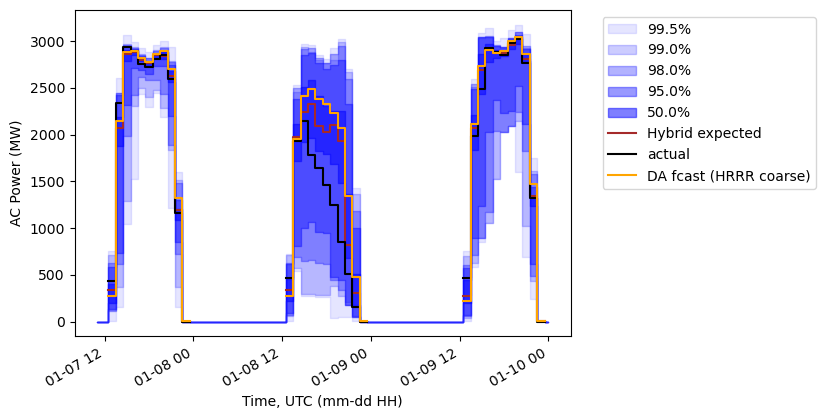

In [84]:
mask_start = '2023-1-7 11:00'
mask_end = '2023-1-10'

mask = (result_df.index >= mask_start) & (result_df.index <= mask_end)

for i in range(num_intervals):
    alph=0.1+(i/10.)
    plt.fill_between(result_df.index[mask],# x
                     result_df[str(percentile_list[i])+'_p_ac'][mask].fillna(0), # lower
                     result_df[str(percentile_list[len(percentile_list)-i-1])+'_p_ac'][mask].fillna(0), # upper
                     color='blue',
                     alpha=alph,
                     step='mid',
                     label=(str(pi_list[i]*100)+'%'))
    
plt.plot(result_df.index[mask],
         result_df[str(percentile_list[int((len(percentile_list)-1)/2)])+'_p_ac'][mask],
         label='Hybrid expected',color='brown', drawstyle='steps-mid')
plt.plot(result_df.index[mask],result_df['p_ac_all_act'][mask],label='actual',color='black', drawstyle='steps-mid')
plt.plot(result_df.index[mask],result_df['p_ac_all_fcast'][mask],label='DA fcast (HRRR coarse)',color='orange', drawstyle='steps-mid')
plt.ylabel('AC Power (MW)')
# plt.ylim([0,4500])
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.gcf().autofmt_xdate()
plt.xlabel('Time, UTC (mm-dd HH)')
plt.show()

We can see that the resulting charts are narrower and appear smoother that the XGboost or Random Forest results by themselves. 

Let's save our results in a pickle file for use later:

In [85]:
result_df.to_pickle('data_files/hybrid_prob_fcast_results_2023.pkl')


This is the end of this notebook, now let's look at how this could be deployed operationally to create forecasts on demand: [10_operational_forecast_example.ipynb](10_operational_forecast_example.ipynb).

(here's some sample code that could be used to export results into a csv file for evaluation in other tools:)

In [86]:
# result_df_hybrid_2023.fillna(0).to_csv('result_df_hybrid_2023.csv')

# filename = 'result_df_hybrid_2023_with_timestamps.csv'

# # make a header        
# header1 = ', '.join(['time'] + result_df_hybrid_2023.columns.to_list()) + '\n'
# header2 = ', '.join(['0'] * (len(result_df_hybrid_2023.columns)+1)) + '\n' 
# with open(filename, 'w') as fp:
#     fp.write(header1)
#     fp.write(header2)

# # write rest of header and write data
# columns = result_df_hybrid_2023.columns
# result_df_hybrid_2023.fillna(0).to_csv(filename, columns = columns, mode='a', index=True, header=False)

# filename = 'result_df_hybrid_2023.csv'

# # make a header        
# header1 = ', '.join(result_df_hybrid_2023.columns.to_list()) + '\n'
# header2 = ', '.join(['0'] * len(result_df_hybrid_2023.columns)) + '\n' 
# with open(filename, 'w') as fp:
#     fp.write(header1)
#     fp.write(header2)

# # write rest of header and write data
# columns = result_df_hybrid_2023.columns
# result_df_hybrid_2023.fillna(0).to_csv(filename, columns = columns, mode='a', index=False, header=False)